In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import keras
from keras.models import load_model
import pickle
import matplotlib.pyplot as plt
from finta import TA
from tqdm import tqdm

# 下載台灣加權指數資料
ticker = '^TWII'
start_date = '2018-01-01'#從訓練資料沒有包括的時間開始做回測
end_date = '2023-02-26'#設置回測結束日期
df = yf.download(ticker, start=start_date, end=end_date)

# 載入模型和Scaler
model = load_model('model.h5')
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# 參考至CHATGPT:https://sharegpt.com/c/CTyoQQ2
def calculate_ta(df):
    ta_functions = [TA.RSI, TA.WILLIAMS, TA.SMA, TA.EMA, TA.WMA, TA.HMA, TA.TEMA, TA.CCI, TA.CMO, TA.MACD, TA.PPO, TA.ROC, TA.CFI, TA.DMI, TA.SAR]
    ta_names = ['RSI', 'Williams %R', 'SMA', 'EMA', 'WMA', 'HMA', 'TEMA', 'CCI', 'CMO', 'MACD', 'PPO', 'ROC', 'CFI', 'DMI', 'SAR']
    for i, ta_func in enumerate(ta_functions):
        try:
            df[ta_names[i]] = ta_func(df)
        except:
            if ta_names[i] == 'MACD':
                df[ta_names[i]] = ta_func(df)['MACD']-ta_func(df)['SIGNAL']
            if ta_names[i] == 'PPO':
                df[ta_names[i]] = ta_func(df)['PPO']-ta_func(df)['SIGNAL']  
            if ta_names[i] == 'DMI':
                df[ta_names[i]] = ta_func(df)['DI+']-ta_func(df)['DI-']
    return df

# 輸入股價資料,scaler,model,輸出(0,1,2)等買進賣出訊號
def process(df,scaler,model):
    df = calculate_ta(df)
    df = df.dropna(axis=0)
    features = df.columns[-15:].tolist()
    Close = df[['Close']]
    df = df[features]
    # 數值轉換
    df[features] = scaler.transform(df[features])
    # 製作X
    days = 15
    start_index = 0
    end_index = len(df)-days
    Xs = []
    indexs = []
    for i in tqdm(range(start_index ,end_index+1 ,1)):
        X = df.iloc[i:i+days,:][features]
        X = np.array(X)
        Xs.append(X)
        indexs.append((df.iloc[[i]].index,df.iloc[[i+days-1]].index))
    Xs = np.array(Xs)
    # 模型預測
    answer = model.predict(Xs)
    answer = [ np.argmax(i) for i in answer]
    
    # 繪圖
    Close = Close.iloc[-len(Xs):,:]
    Close['SIGNAL'] = answer
    buy = Close[Close['SIGNAL']==1]['Close']
    sell = Close[Close['SIGNAL']==2]['Close']
    Close['Close'].plot()
    plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
    plt.scatter(list(sell.index),list(sell.values),color='green',marker='v')
    plt.show()
    
    return answer

# 回測策略
def backtest(df, model, scaler):
    # 預測結果
    signals = process(df,scaler,model)
    df = df.iloc[-len(signals):,:]
    
    # 初始資金
    capital = 1000000
    init_capital = 1000000
    # 初始股份
    stock = 0
    #報資產序列
    total_capital_list = []

    # 進場價格跟時間
    entry_price = None
    entry_time = None

    # 每次買入幾股
    buy_qty = 50
    
    # 回測主要邏輯,考慮進出場條件,例如停損停利法,固定持有時間法
    for i in range(1, len(df)):
        # 如果前刻為買進狀態，而此時為賣出狀態
        if signals[i] == 2 and signals[i-1] == 1:
            # 賣出賺錢
            if stock > 0: #檢查是否有股票可以賣
                capital += df['Close'][i]*stock #價格*股數
                stock = 0 #賣光了
        # 如果前刻為賣出狀態，而此時為買進狀態
        elif signals[i] == 1 and signals[i-1] == 2:
            # 買入股票
            if capital - df['Close'][i]*buy_qty > 0: #檢查是否買得起
                capital -= df['Close'][i]*buy_qty #價格*股數
                stock += buy_qty #買入特定數量股數
                entry_price = df['Close'][i] #紀錄進場價格
                entry_time = i #紀錄進場時間
        # 達到停損停利點也要賣出股票
        if entry_price != None:
            if (df['Close'][i] >= entry_price*1.03) or(df['Close'][i] <= entry_price*0.97):#達到停損停利條件
                if stock > 0:#檢查是否有股票賣
                    capital += df['Close'][i]*stock #價格*股數
                    stock = 0 #賣光了
        # 達到預設持有時間也要賣出股票
        if entry_time != None:
            if i - entry_time == 20: #達到預設持有時間
                if stock > 0: #檢查是否有股票賣
                    capital += df['Close'][i]*stock #價格*股數
                    stock = 0 #賣光了
        # 計算總資產變化
        total_capital = capital + stock*df['Close'][i] #現金和股票價值合計
        total_capital_list.append(total_capital)


    # 繪製報酬率曲線圖
    plt.plot(total_capital_list, label='TWII')
    plt.legend()
    plt.title(f'Total capital: {total_capital_list[-1]}')
    plt.show()
    return total_capital_list

[*********************100%***********************]  1 of 1 completed


100%|██████████| 1197/1197 [00:01<00:00, 1189.06it/s]


38/38 [==============================] - 0s 4ms/step


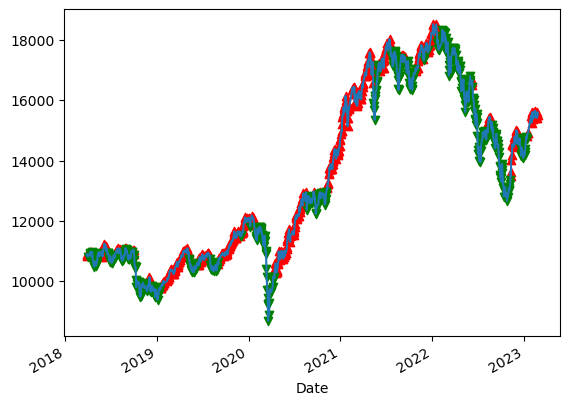

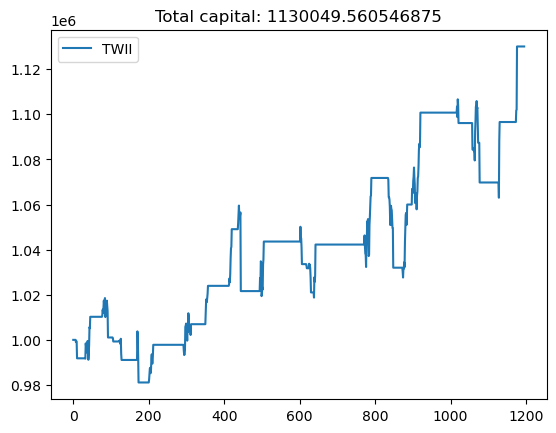

In [2]:
total_capital_list = backtest(df, model, scaler)

In [3]:
print('總報酬率:',((total_capital_list[-1]/total_capital_list[0])-1)*100,'%')
print('過程中最大報酬率:',((max(total_capital_list)/total_capital_list[0])-1)*100,'%')

總報酬率: 13.0049560546875 %
過程中最大報酬率: 13.0049560546875 %
